<a href="https://colab.research.google.com/github/jp-ishimwe/Projects/blob/master/T5_ftransfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Import packages { run: "auto", vertical-output: true, display-mode: "both" }
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.base import BaseEstimator, TransformerMixin
import progressbar
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import pickle
import dill
import tarfile
import json, gzip


!pip install transformers -q

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from transformers import T5Tokenizer, T5ForConditionalGeneration
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau


import warnings
warnings.filterwarnings('ignore')

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#!cp '/content/drive/My Drive/Colab Notebooks/optimizers.py' .

#from optimizers import AdaFactor

In [ ]:
!nvidia-smi
!/usr/local/cuda/bin/nvcc --version

Wed Jul 15 14:31:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    32W / 149W |     11MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#@title To proceed should be cuda { run: "auto", vertical-output: true }
CUDA = torch.cuda.is_available()
device = torch.device("cuda" if CUDA else "cpu")
print(device)

cuda


#### Getting dataset

You can find the dataset [here](http://lil.nlp.cornell.edu/newsroom/download/index.html)

**Loading data**

In [ ]:
fname = '/content/drive/My Drive/Colab Notebooks/newsroom-release.tar'

tar = tarfile.open(fname, "r:")
tar.extractall()
tar.close()

In [ ]:
!mv '/content/data/' '/content/drive/My Drive/Colab Notebooks'

In [ ]:
!cp -r '/content/release/' '/content/drive/My Drive/Colab Notebooks/data'

In [ ]:
path = "/content/drive/My Drive/Colab Notebooks/data/release/"

def read_data(path, name):
  data = []
  with gzip.open(path + name +".jsonl.gz" ) as f:
      for ln in f:
          obj = json.loads(ln)
          data.append(obj)
  return data

trainset = read_data(path, 'train')
#devset = read_data(path, 'dev')
#testset = read_data(path, 'test')

In [ ]:
def get_data(data):
  data_dict = {'text': [], 'summary': []}
  for article in data:
    data_dict['text'].append(article['text'])
    data_dict['summary'].append(article['summary'])
  return pd.DataFrame(data_dict)

train_data = get_data(trainset)
# valid_data = get_data(validset)
# test_data = get_data(testset)

In [ ]:
train_data.head()

,text,summary
0,"HAMBURG, Germany, June 3  As he left the socc...",A surge in discriminatory behavior toward blac...
1,"WASHINGTON, Dec. 23 - The National Security Ag...","The volume of information harvested, without \..."
2,IF outsized executive pay has indeed become a ...,The battle between Pfizer Inc.'s investors and...
3,BY A.J. BENZA & MICHAEL LEWITTES\n\nIf Simon R...,"If Simon Rex looks a little familiar, it may n..."
4,Spinach has terrorized generations of veggie-p...,POPEYE-WORTHY PIE. PHYLLO DOUGH WRAPS SPINACH ...


In [ ]:
print(f'The size of data:{train_data.shape}')

The size of data:(995041, 2)


In [ ]:
for i , b in enumerate(train_data['text'][100:200]):
  print(f'artcle: {i} {b}')

artcle: 0 Candlestick Park has been my part-time office for more than two decades. But, from a sentimental standpoint, it has always felt more like a room in my childhood home, full of faded memories, familiar smells and an odd kind of (cold, windy and damp) comfort.

Candlestick Park will always be for me, first and foremost, not about Joe Montana or Willie Mays but about my dad.

When a team moves to swanky new digs and the building left behind becomes an empty shell, and eventually a pile of rubble, where do all our memories go? The Stick is packed with the ghosts of family legends, traces of generations' worth of outings, spirits of memorable moments of bonding.

My dad's spirit is there. My 100 percent Irish father loved good stories, a big laugh and sports drama. And Candlestick Park provided plenty of all three.

My father was thrilled when the Giants moved west, standing on Montgomery Street to greet them as ticker tape showered down upon him and my older brother, who was perch

In [ ]:
# for i , b in enumerate(train_data['summary'][:100]):
#   print(f'artcle: {i} {b}')

artcle: 0 A surge in discriminatory behavior toward blacks by fans and other players threatens to embarrass soccer.
artcle: 1 The volume of information harvested, without 
court warrants, is much larger than the White 
House has acknowledged.
artcle: 2 The battle between Pfizer Inc.'s investors and its board illustrates an imbalance of power between company owners and managers that is prevalent today.
artcle: 3 If Simon Rex looks a little familiar, it may not have anything to do with his gig as an MTV veejay or his ads for Levi's and Tommy Hilfiger. It could be because Rex did a little film work once upon a time three skin flicks to be precise! In case you missed his work, Rex' oeuvre includes titles like "Young, Hard & Solo II,"its poignant sequel, "Young, Hard & Solo III,"
artcle: 4 POPEYE-WORTHY PIE. PHYLLO DOUGH WRAPS SPINACH IN PURE GOLD BY ROSEMARY BLACK Spinach has terrorized generations of veggie-phobic kids, and many grownups don't much like it, either. But when it's combined 

In [ ]:
contraction = {"isn't": "is not", "aren't": "are not","can't": "cannot", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you ll":"you will", "you'll've": "you will have",
                           "you're": "you are", "you re": "you are" , "you've": "you have"}

###### Checking for NA

In [ ]:
train_data.isnull().sum()

text       0
summary    0
dtype: int64

we have 818 articles without summaries

In [ ]:
# new_wikihowAll = wikihowAll[['text', 'headline']]
# new_wikihowAll = new_wikihowAll.dropna(how='all')
row = TextProccessing('summary', contraction)
d = row.fit_transform(train_data)

In [ ]:
d[17]

'OUR GAME By John le Carre Knopf. 24 ONE OF THESE YEARS, John le Carre will write a novel that falls short of his admirers expectations, but 1995 is not the year. Our Game continues the remarkable record of high tension excellence that began with The Spy Who Came in From the Cold. At its simplest, this new and 15th overall novel is a mystery. A devious and delicious mystery. A man is missing,'

In [ ]:
a = tokenizer.encode_plus(train_data['summary'][17])

In [ ]:
j = [tokenizer.convert_ids_to_tokens(idx) for idx in a['input_ids']]
j

['▁',
 'OUR',
 '▁G',
 'AME',
 '▁By',
 '▁John',
 '▁le',
 '▁Car',
 're',
 '▁(',
 'K',
 'n',
 'o',
 'p',
 'f',
 '.',
 '▁$2',
 '4)',
 '▁',
 'ONE',
 '▁OF',
 '▁THE',
 'SE',
 '▁YEAR',
 'S',
 ',',
 '▁John',
 '▁le',
 '▁Car',
 're',
 '▁will',
 '▁write',
 '▁',
 'a',
 '▁novel',
 '▁that',
 '▁falls',
 '▁short',
 '▁of',
 '▁his',
 '▁admir',
 'ers',
 "'",
 '▁expectations',
 ',',
 '▁but',
 '▁1995',
 '▁is',
 '▁not',
 '▁the',
 '▁year',
 '.',
 '▁"',
 'Our',
 '▁Game',
 '"',
 'continu',
 'e',
 's',
 '▁the',
 '▁remarkable',
 '▁record',
 '▁of',
 '▁high',
 '-',
 'tension',
 '▁excellence',
 '▁that',
 '▁began',
 '▁with',
 '▁"',
 'The',
 '▁Sp',
 'y',
 '▁Who',
 '▁Cam',
 'e',
 '▁in',
 '▁From',
 '▁the',
 '▁Cold',
 '."',
 'A',
 't',
 '▁its',
 '▁',
 'simplest',
 ',',
 '▁this',
 '▁new',
 '▁(',
 'and',
 '▁15',
 'th',
 '▁overall',
 ')',
 '▁novel',
 '▁is',
 '▁',
 'a',
 '▁mystery',
 '.',
 '▁A',
 '▁de',
 'vious',
 '▁and',
 '▁delicious',
 '▁mystery',
 '.',
 '▁A',
 '▁man',
 '▁is',
 '▁missing',
 ',']

In [ ]:
#new_wikihowAll.isnull().sum()


'OUR GAME By John le Carre (Knopf. $24) ONE OF THESE YEARS, John le Carre will write a novel that falls short of his admirers\' expectations, but 1995 is not the year. "Our Game"continues the remarkable record of high-tension excellence that began with "The Spy Who Came in From the Cold."At its simplest, this new (and 15th overall) novel is a mystery. A devious and delicious mystery. A man is missing,'

In [ ]:
#indices = np.where(new_wikihowAll['text'].isna())

In [ ]:
# new_wikihowAll = new_wikihowAll.dropna().reset_index(drop=True)
# new_wikihowAll.isnull().sum()

In [ ]:
# h = new_wikihowAll

# for x in ['text', 'headline']:
# 		h[x+'_tokenized'] = h[x].apply(lambda x:x.lower().split() );
# 		h[x+'_len'] = h[x+'_tokenized'].apply(lambda x: len(x))
# min(h['headline_len']), min(h['text_len']), len(h[h['headline_len']==1]), len(h[h['text_len']==0])

#####Preprocessing

In [ ]:
class TextProccessing(BaseEstimator, TransformerMixin):
  def __init__(self, column, contraction):
    self.column = column
    self.contraction = contraction
  def fit(self, x, y=None):
    return self
  @staticmethod
  def preprocessing(line):
    
    #line = line.lower() 
    line = re.sub(r"http\S+", " ",line)
    line = re.sub(r'[^\sa-zA-Z0-9.,!?$£]',' ',line)
    line = line.replace('—', ' ')
    line = line.replace('*', ' ')
    line = line.strip(' ')
    line = line.replace("share on facebook", "")
    line = line.replace("click to share on twitter", "")
    line = re.sub(r'\s{2,}',' ', line)

    return line

  def transform(self, X):
    #X = X[self.column].replace(self.contraction)
    return X[self.column].replace(self.contraction).fillna('').apply(lambda x: self.preprocessing(x)) 

In [ ]:
class Processor:

  def __init__(self, data, 
               contraction,
               max_length = None):
    
    self.max_length = max_length
    self.data = data
    self.contraction = contraction
    #self.textproc = textproc

  def cleaning(self, data):
    if not isinstance(data, pd.DataFrame):
      raise TypeError('Only Dataframes are allowed, but got data={}'.format(data))
    else:
      print('Please wait, we are cleaning...')
      titles = ['summary', 'text']
      data_dict = {}
      good = []

      for title in titles:
        proc = TextProccessing(title, self.contraction)
        res = proc.fit_transform(data)
        if title == 'summary':    
          for tt in res:
            row = ' '.join(tt.split('\n'))
            good.append(row.strip())
        data_dict[title] = res

      dd = pd.DataFrame(good)
      dd.columns = ['summary']
      ss = pd.DataFrame(data_dict)
      ss = ss.drop(columns='summary', axis=1)
      dataset = pd.concat([ss, dd], axis=1)
      
      return dataset

  @staticmethod
  def split(data):
    return len(data.split())

  def get_max_tokens(self, dataframe):

    dataframe['article_len'] = dataframe['text'].apply(self.split)
    dataframe['summary_len'] = dataframe['summary'].apply(self.split)
    
    max_len = {'max_article_tokens': max(dataframe['article_len']), 
                'min_article_tokens': min(dataframe['article_len']),
                'max_summary_tokens': max(dataframe['summary_len']),
                'min_summary_tokens': min(dataframe['summary_len'])}
    return max_len, dataframe

  def cleaned_data(self):
    dataframe = self.cleaning(self.data)
    
    if self.max_length is None:
      max_len, dataframe = self.get_max_tokens(dataframe)
    else:
      max_len = self.max_length

    min_length = max_len['min_article_tokens']
    idx_list = []
    for idx, paragraph in tqdm(enumerate(dataframe)):
        pragraph = len(paragraph.split())
        if pragraph <= min_length:
          idx_list.append(idx)
    final_data = dataframe.drop(idx_list)
    final_data = final_data.reset_index(drop=True)

    _, final_data = self.get_max_tokens(final_data)

    print('Done!')
    return final_data, max_len

In [ ]:
maxlen = {'max_article_tokens': 512,
          'max_summary_tokens': 300,
          'min_article_tokens': 30,
          'min_summary_tokens': 0}

In [ ]:
textproc = Processor(new_wikihowAll,contraction)#, maxlen)
dataset, max_len = textproc.cleaned_data()

Please wait, we are cleaning...



Done!


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214294 entries, 0 to 214293
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   text         214294 non-null  object
 1   headline     214294 non-null  object
 2   article_len  214294 non-null  int64 
 3   summary_len  214294 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 6.5+ MB


In [ ]:
max_len

{'max_article_tokens': 12394,
 'max_summary_tokens': 4341,
 'min_article_tokens': 0,
 'min_summary_tokens': 1}

In [ ]:
dataset['summary_len'].quantile([0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999])

0.5000      44.0000
0.7500      77.0000
0.9000     122.0000
0.9500     159.0000
0.9900     266.0000
0.9990     503.0000
0.9999    1024.9796
Name: summary_len, dtype: float64

In [ ]:
dataset['article_len'].quantile([0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999])

0.5000     306.0000
0.7500     550.0000
0.9000    1049.0000
0.9500    1484.0000
0.9900    2364.0700
0.9990    3665.1210
0.9999    5201.5503
Name: article_len, dtype: float64

In [ ]:
art = int(dataset['article_len'].quantile(0.9900))
sum = int(dataset['summary_len'].quantile(0.9900))

print(f'art len:{art}, sum len:{sum}')

art len:2364, sum len:266


#### Creating Custom Dataset

In [ ]:
class CustomDataReader(Dataset):
  """
  Loading data to be used in pytorch pre-trained models
  
  """
  def __init__(self, dataframe, T5tokenizer, **kwargs):
    self.tokenizer = T5tokenizer
    self.dataframe = dataframe
    self.articles = dataframe.text
    self.summary  = dataframe.headline
    self.source_len = kwargs.get('max_article_tokens', 512)
    self.target_len = kwargs.get('max_summary_tokens', 150)
  
  def __len__(self):
    return len(self.articles)

  def __getitem__(self, idx):
    articles = self.articles[idx]
    articles = ' '.join(articles.split())

    summary = self.summary[idx]
    summary = ' '.join(summary.split())

    source_tokenized = self.tokenizer.batch_encode_plus([articles], max_length= self.source_len, pad_to_max_length=True, truncation=True,return_tensors='pt')
    target_tokenized = self.tokenizer.batch_encode_plus([summary], max_length= self.target_len, pad_to_max_length=True, truncation=True,return_tensors='pt')

    source_ids = source_tokenized['input_ids'].squeeze(0)
    source_mask = source_tokenized['attention_mask'].squeeze(0)

    summary_ids = target_tokenized['input_ids'].squeeze(0)
    summary_mask = target_tokenized['attention_mask'].squeeze(0)

    return source_ids, source_mask, summary_ids, summary_mask


#### Training Loop

In [ ]:
def training(model, dataset_loader, optimizer, iteration=0):

  model.train()
  avg_loss = 0
  nItem = 0


  print(f'Start training for epoch: {iteration}')
 
  for idx, data_train in enumerate(dataset_loader):

    input_ids, source_mask, summary_ids, summary_mask = data_train

    input_ids = input_ids.to(device, dtype = torch.long)
    source_mask = source_mask.to(device, dtype = torch.float)
    summary_ids = summary_ids.to(device, dtype = torch.long)

    target_labels = summary_ids[:, :-1].contiguous()
    langm_labels = summary_ids[:, 1:].clone().detach()
    langm_labels[summary_ids[:, 1:] == tokenizer.pad_token_id] = -100

    optimizer.zero_grad()
    
    output = model(input_ids=input_ids, attention_mask = source_mask, decoder_input_ids=target_labels, lm_labels=langm_labels, output_hidden_states=True)
    
    loss = output[0]

    loss.backward()
    optimizer.step()

    bs = input_ids.size(0)
    nItem += bs

    avg_loss += loss.item() * bs
    if idx % 100 == 0:
      print(f'[{idx * len(input_ids)}/{len(dataset_loader.dataset)} ({100. * idx / len(dataset_loader):.0f})%] \t Training loss: {loss:.3f}')
  
  avg_loss /= nItem
  
  return avg_loss, output


In [ ]:
def validation(model, dataset_loader):
  model.eval()

  eval_loss = 0
  nItem = 0

  with torch.no_grad():
    for idx, data_val in tqdm(enumerate(dataset_loader)):

      input_ids, source_mask, summary_ids, summary_mask = data_val

      input_ids = input_ids.to(device, dtype = torch.long)
      source_mask = source_mask.to(device, dtype = torch.float)
      summary_ids = summary_ids.to(device, dtype = torch.long)

      target_labels = summary_ids[:, :-1].contiguous()
      langm_labels = summary_ids[:, 1:].clone().detach()
      langm_labels[summary_ids[:, 1:] == tokenizer.pad_token_id] = -100
      
      output = model(input_ids=input_ids, attention_mask = source_mask, decoder_input_ids=target_labels, lm_labels=langm_labels)
      
      loss = output[0]

      bs = input_ids.size(0)
      nItem += bs

      eval_loss += loss.item()

    eval_loss /= nItem

    return eval_loss

In [ ]:
def saving(PATH, epoch, avg_loss, model,pp, LEARNING_RATE):
  torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'train_loss': avg_loss,
            'perplexity': pp,
            'learning_rate': LEARNING_RATE
            }, PATH)

#### The model evaluation

The perplexity:

\begin{align}
\large \text{ppl}(p, D) &\large = 2^{-\frac{1}{N_{total}}\log_2 p(D)}
\end{align}

where $D=\{(w_1,\ldots,w_{N_i})_i\}_{i=1}^M$ is a dataset of $M$ sequences with total length $N_{\text{total}}=\sum_{i}N_i$.

#### Computing perplexity

Our model's loss is the (negative) log probability of every token in the output sequence, which can be used to compute perplexity.

We define perplexity using the **base 2** logarithm.

In [ ]:
def get_perplexity(epoc_loss):
  rs = epoc_loss/np.log(2)
  pp = 2**rs
  return pp

In [ ]:
#@title #### Loading T5 model and its Tokenizer { run: "auto" }

LEARNING_RATE = 3e-4
MODEL_NAME = 't5-base' # or T5-Large:770 params, T5-3B, T5-Base: 220 Params, T5-11B
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
#optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
optimizer = AdaFactor(model.parameters(), lr=LEARNING_RATE)

scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=0)

model = model.to(device)

In [ ]:
eos = tokenizer.eos_token
sos = tokenizer.pad_token
eos, sos

('</s>', '<pad>')

In [ ]:
#@title Train, Validation and Test splits { run: "auto" }

eos = ' </s>'  #tokenizer.eos_token
sos = '<pad> ' #tokenizer.pad_token

dataset.text = "summarize: " + dataset.text + eos # for T5 conformity
dataset.headline = sos + dataset.headline + eos
columns = ["text","headline"]

df = dataset[columns]
X_train, X_val = train_test_split(df, test_size=0.1, random_state = 42)

X_train = X_train.reset_index(drop=True)
X_test = X_val.reset_index(drop=True)

In [ ]:
X_train.head()

,text,headline
0,summarize: this calendar of events is availabl...,"<pad> consult the formula 1 race calendar., pi..."
1,summarize: once you ve finished your self anal...,"<pad> fix the problem., make a conscious effor..."
2,summarize: stir it thoroughly and then set it ...,<pad> add 1 teaspoon 4.9 ml of borax to 500 mi...
3,summarize: recognizing that you need to establ...,"<pad> decide to set boundaries., define the bo..."
4,summarize: communicate with your significant o...,<pad> talk with your significant other about y...


In [ ]:
# train_size = 0.8
# train_dataset=df.sample(frac=train_size, random_state = SEED).reset_index(drop=True)
# val_dataset=df.drop(train_dataset.index).reset_index(drop=True)

In [ ]:
#d = ' '.join(X_train.iloc[0]['text'].split())
#d

In [ ]:
#d = ' '.join(X_train.iloc[0]['headline'].split())
#d

In [ ]:
X_train = X_train.iloc[:2000]
X_test = X_test.iloc[:600]

In [ ]:
args = {'max_article_tokens': 512,
          'max_summary_tokens': 150}

train_set = CustomDataReader(X_train, tokenizer,**args)
val_set = CustomDataReader(X_test, tokenizer,**args)

In [ ]:
BATCH_SIZE = 4
train_params = {
        'batch_size': BATCH_SIZE,
        'shuffle': True,
        'num_workers': 2
        }

val_params = {
    'batch_size': BATCH_SIZE,
    'shuffle': False,
    'num_workers': 2
    }

train_loader = DataLoader(train_set, **train_params)
val_loader = DataLoader(val_set, **val_params)

In [ ]:
N_EPOCHS = 15
path = '/content/drive/My Drive/Colab Notebooks/best_model.pth'
pcle = '/content/drive/My Drive/Colab Notebooks/optimizer_state_dict.pkl'
filename = open(pcle, 'wb')

In [ ]:
def run(N_EPOCHS, model, train_loader, val_loader, optimizer, path, filename, lr= LEARNING_RATE):

  #best_loss = float('inf')
  best_pp = float('inf')

  train_loss = []
  val_loss = []
  perplexity = []

  for epoch in range(N_EPOCHS):

    avg_loss, outputs = training(model, train_loader, optimizer, iteration=epoch)
    print('\nValidation start:')
    eval_loss = validation(model, val_loader)
    
    pp = get_perplexity(eval_loss)
    
    perplexity.append(pp)
    train_loss.append(avg_loss)
    val_loss.append(eval_loss)
    scheduler.step(eval_loss)

    
    print(f'Epoch loss: {avg_loss:.2f}')
    print(f'Perplexity: {pp:.3f} | Eval loss: {eval_loss:.2f}')
    print("--------------")


    if pp < best_pp:
      best_pp = pp
      saving(path, epoch, avg_loss, model, pp, lr)
      dill.dump(optimizer, filename)

    # Save model for every 3 epochs
    # if i%3==0:
    #   torch.save(model.state_dict(), path)
  print(f'Best Perplexity: {best_pp}')
  filename.close()

  return train_loss, perplexity, val_loss, outputs

In [ ]:
train_loss, perplexity, eval_loss, outputs = run(N_EPOCHS, model, train_loader, val_loader, optimizer, path, filename)

Start training for epoch: 0
[0/2000 (0)%] 	 Training loss: 2.290
[400/2000 (20)%] 	 Training loss: 1.788
[800/2000 (40)%] 	 Training loss: 1.877
[1200/2000 (60)%] 	 Training loss: 1.744
[1600/2000 (80)%] 	 Training loss: 1.879

Validation start:



Epoch loss: 2.16
Perplexity: 1.819 | Eval loss: 0.60
--------------
Start training for epoch: 1
[0/2000 (0)%] 	 Training loss: 1.844
[400/2000 (20)%] 	 Training loss: 2.476
[800/2000 (40)%] 	 Training loss: 2.162
[1200/2000 (60)%] 	 Training loss: 1.940
[1600/2000 (80)%] 	 Training loss: 1.635

Validation start:



Epoch loss: 1.86
Perplexity: 1.855 | Eval loss: 0.62
--------------
Start training for epoch: 2
[0/2000 (0)%] 	 Training loss: 1.272
[400/2000 (20)%] 	 Training loss: 1.563
[800/2000 (40)%] 	 Training loss: 1.591
[1200/2000 (60)%] 	 Training loss: 2.472
[1600/2000 (80)%] 	 Training loss: 1.661

Validation start:



Epoch loss: 1.54
Perplexity: 1.899 | Eval loss: 0.64
--------------
Start training for epoch: 3
[0/2000 (0)%] 	 Training loss: 1.354
[400/2000 (20)%] 	 Training loss: 1.350
[800/2000 (40)%] 	 Training loss: 1.180
[1200/2000 (60)%] 	 Training loss: 1.844
[1600/2000 (80)%] 	 Training loss: 1.183

Validation start:



Epoch loss: 1.31
Perplexity: 1.943 | Eval loss: 0.66
--------------
Start training for epoch: 4
[0/2000 (0)%] 	 Training loss: 1.010
[400/2000 (20)%] 	 Training loss: 0.689
[800/2000 (40)%] 	 Training loss: 0.824
[1200/2000 (60)%] 	 Training loss: 1.255
[1600/2000 (80)%] 	 Training loss: 0.739

Validation start:



Epoch loss: 1.19
Perplexity: 1.995 | Eval loss: 0.69
--------------
Start training for epoch: 5
[0/2000 (0)%] 	 Training loss: 1.290
[400/2000 (20)%] 	 Training loss: 0.887
[800/2000 (40)%] 	 Training loss: 1.060
[1200/2000 (60)%] 	 Training loss: 1.293
[1600/2000 (80)%] 	 Training loss: 1.050

Validation start:



Epoch loss: 1.14
Perplexity: 2.014 | Eval loss: 0.70
--------------
Start training for epoch: 6
[0/2000 (0)%] 	 Training loss: 1.392
[400/2000 (20)%] 	 Training loss: 1.152
[800/2000 (40)%] 	 Training loss: 1.309
[1200/2000 (60)%] 	 Training loss: 0.932
[1600/2000 (80)%] 	 Training loss: 1.429

Validation start:



Epoch loss: 1.10
Perplexity: 2.026 | Eval loss: 0.71
--------------
Start training for epoch: 7
[0/2000 (0)%] 	 Training loss: 1.230
[400/2000 (20)%] 	 Training loss: 0.840
[800/2000 (40)%] 	 Training loss: 1.455
[1200/2000 (60)%] 	 Training loss: 1.207
[1600/2000 (80)%] 	 Training loss: 0.923

Validation start:



Epoch loss: 1.09
Perplexity: 2.033 | Eval loss: 0.71
--------------
Start training for epoch: 8
[0/2000 (0)%] 	 Training loss: 1.404
[400/2000 (20)%] 	 Training loss: 0.717
[800/2000 (40)%] 	 Training loss: 1.151
[1200/2000 (60)%] 	 Training loss: 0.764
[1600/2000 (80)%] 	 Training loss: 0.528

Validation start:



Epoch loss: 1.09
Perplexity: 2.035 | Eval loss: 0.71
--------------
Start training for epoch: 9
[0/2000 (0)%] 	 Training loss: 1.010
[400/2000 (20)%] 	 Training loss: 1.327
[800/2000 (40)%] 	 Training loss: 1.751
[1200/2000 (60)%] 	 Training loss: 0.928
[1600/2000 (80)%] 	 Training loss: 1.037

Validation start:



Epoch loss: 1.08
Perplexity: 2.035 | Eval loss: 0.71
--------------
Start training for epoch: 10
[0/2000 (0)%] 	 Training loss: 1.150
[400/2000 (20)%] 	 Training loss: 1.171
[800/2000 (40)%] 	 Training loss: 1.303
[1200/2000 (60)%] 	 Training loss: 1.005
[1600/2000 (80)%] 	 Training loss: 0.775

Validation start:



Epoch loss: 1.08
Perplexity: 2.036 | Eval loss: 0.71
--------------
Start training for epoch: 11
[0/2000 (0)%] 	 Training loss: 1.249
[400/2000 (20)%] 	 Training loss: 1.168
[800/2000 (40)%] 	 Training loss: 1.094
[1200/2000 (60)%] 	 Training loss: 1.298
[1600/2000 (80)%] 	 Training loss: 0.703

Validation start:



Epoch loss: 1.09
Perplexity: 2.036 | Eval loss: 0.71
--------------
Start training for epoch: 12
[0/2000 (0)%] 	 Training loss: 1.277
[400/2000 (20)%] 	 Training loss: 1.062
[800/2000 (40)%] 	 Training loss: 1.260
[1200/2000 (60)%] 	 Training loss: 1.389
[1600/2000 (80)%] 	 Training loss: 0.476

Validation start:



Epoch loss: 1.08
Perplexity: 2.036 | Eval loss: 0.71
--------------
Start training for epoch: 13
[0/2000 (0)%] 	 Training loss: 0.836
[400/2000 (20)%] 	 Training loss: 1.121
[800/2000 (40)%] 	 Training loss: 1.028
[1200/2000 (60)%] 	 Training loss: 0.775
[1600/2000 (80)%] 	 Training loss: 0.836

Validation start:



Epoch loss: 1.08
Perplexity: 2.036 | Eval loss: 0.71
--------------
Start training for epoch: 14
[0/2000 (0)%] 	 Training loss: 0.837
[400/2000 (20)%] 	 Training loss: 1.374
[800/2000 (40)%] 	 Training loss: 0.812
[1200/2000 (60)%] 	 Training loss: 1.237
[1600/2000 (80)%] 	 Training loss: 1.320

Validation start:



Epoch loss: 1.07
Perplexity: 2.036 | Eval loss: 0.71
--------------
Best Perplexity: 1.8192332581803736


Text(0.5, 1.0, 'Train loss')

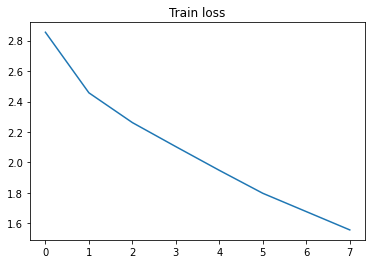

In [ ]:
import matplotlib.pyplot as plt

tr_los = np.array(train_loss)
ev_los = np.array(eval_loss)
per = np.array(perplexity)

plt.plot(tr_los, label='Training loss')
plt.plot(ev_los, label='Validation loss')
plt.plot(per, label='Perplexity on val data')

plt.legend(frameon=False)
plt.title('Train loss vs Eval loss and Perplexity')
plt.show()

In [ ]:
def generator(model, dataset_loader):
  
  model.eval()

  results = {"generated_summary": [], "golden_summary": []}

  with torch.no_grad():

    for idx, data_val in enumerate(dataset_loader):
      
      input_ids, source_mask, summary_ids, summary_mask = data_val 
      
      input_ids = input_ids.to(device, dtype = torch.long)
      source_mask = source_mask.to(device, dtype = torch.float)
      summary_ids = summary_ids.to(device, dtype = torch.long)

      generatation = model.generate(input_ids=input_ids,
                                    attention_mask=source_mask, 
                                    min_length=30, 
                                    max_length=300, 
                                    num_beams=3,
                                    repetition_penalty=2.5,
                                    eos_token_id = model.config.eos_token_id,               
                                    length_penalty=1.0, 
                                    early_stopping=True
                                    )

      for gen, sc in zip(generatation, summary_ids): # Taking whole document IDs and docode the summary

        gen_tokens_dec = tokenizer.decode(gen, skip_special_tokens=True, clean_up_tokenization_spaces=True)
        sc_tokens_dec = tokenizer.decode(sc, skip_special_tokens=True, clean_up_tokenization_spaces=True)

        results["generated_summary"].append(gen_tokens_dec)
        results["golden_summary"].append(sc_tokens_dec)

  return results


#### Loading Saved Model

In [ ]:
model = .... # first initialize the model and optimizer

#optimizer = ... # optimizer then,
infile = open(pcle,'rb')
optimizer = pickle.load(infile)
infile.close()

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [ ]:
%time results = generator(model, val_loader)

CPU times: user 1h 34min 40s, sys: 8min 4s, total: 1h 42min 45s
Wall time: 1h 42min 46s


#### Visualizing examples

**Example 1**

In [ ]:
print("Actual summary:")
results['golden_summary'][0]

Actual summary:


'insert the black probe into the common terminal and the red probe into the terminal marked for measuring ohms, volts or diode test., use the selector knob to choose the test diode function., turn the power off to the circuit., test forward bias., reverse the probes to test reverse bias., a reading of ol or 0 while testing forward bias, and 0 while testing reverse bias indicates that the diode is bad.'

In [ ]:
print('Generated summary:')
results['generated_summary'][0]

Generated summary:


'the display will beep when the reading is less than 1., place the diode on the positive and negative side of the diode., measure the forward bias., check to see if the display reads ol overload., check to see if the reading is more than 0., check to see if the diode is shorted., test for reverse bias., check to see if the display displays a beep., check to see if there is a shorted diode indicates a shorted diode., turn off the display., switch off the diode., change the power supply., adjust the power supply voltage., reset the power supply voltage., set the power supply voltage., restart the power supply voltage., start the power supply voltage., repeat until the power supply voltage is equal to or greater than 1 volts., stop the power supply voltage., turn off the power supply voltage., turn off the power supply voltage., turn off the power supply voltage., turn off the power supply voltage., turn off the power supply voltage., turn off the power supply voltage., turn off the power

**Example 2**

In [ ]:
X_test.iloc[10,:]['text']

'summarize: marshmallows are very sticky, so you need to start with a greased pan. spray down a 9 by 13 inch pan 23 centimeters by 33 centimeters with cooking spray. it can also help to spray down any utensils you re going to use. the mixture will stick to anything., mix the packets of gelatin with about half a cup 125 milliliters of water and the vanilla extract in the bowl of a stand mixer. just use a fork to mix them together. let the mixture sit to the side for a few minutes so the gelatin can bloom hydrate .try to get all the lumps out with the fork.\nyou can also use extracts like raspberry, lemon, orange, almond, or banana, depending on what you want to do with the marshmallows. , add 1 2 cup 125 milliliters of water to a small pan. pour in the sugar or the sugar plus the corn syrup, whichever you re using. bring it to a boil over medium to high heat, and let it boil until it reaches 250 degrees fahrenheit 121 degrees celsius or just under. continually wipe down the insides of t

In [ ]:
print("Actual summary:")
results['golden_summary'][10]

Actual summary:


'grease the pan., hydrate the gelatin., make the simple syrup., mix the gelatin in.'

In [ ]:
print('Generated summary:')
results['generated_summary'][10]

Generated summary:


'the marshmallows will stick to any cooking spray or utensils., mix the gelatin and water in a mixing bowl., bring the sugar and water to a boil., heat the mixture until it reaches 250 degrees fahrenheit 121 degrees celsius., pour the gelatin into the pan., add the corn syrup., let it cool down., make the gelatin., remove the marshmallows from the pan., cut the marshmallows into chunks., bake the marshmallows on top of the marshmallows., serve the marshmallows., enjoy!, finish your marshmallows., finished., place the marshmallows back on top of the marshmallows., repeat steps 1 2 3 4 times., use a stand mixer., stir everything together., store at room temperature., serve., refrigerate the marshmallows for up to servings., wrap the marshmallows., decorate the top of the marshmallows., sprinkle the top of the marshmallows., spread the marshmallows., put the marshmallows., cook the marshmallows., serve immediately., serve immediately., serve immediately., serve immediately., serve immedia

**Example 3**

In [ ]:
X_test.iloc[3,:]['text']

'summarize: now download the setup for your operating system by clicking on the link right besides the package name. for this article, i have downloaded, virtualbox 4.3.16 for windows hosts. make sure you download the latest version of virtualbox for your operating system. i am presently working on windows 8.1. ,,, if you like to place a shortcut icon for virtualbox on your desktop and in the quick launch bar, leave the first two boxes selected. ,\xa0this will help you to access internet and other network resources from windows 10. , now sit back and chillax while virtualbox installs on your system. depending on the security settings on your operating system and available system drivers, your operating system may ask you to allow or deny the setup proceed and install few drivers. this is essential for your virtualbox to let windows 10 access hardware and other resources on your host operating system the operating system you are using right now . you may choose to accept and install the

In [ ]:
print("Actual summary:")
results['golden_summary'][3]

Actual summary:


'visit and look for a list of virtualbox platform packages., run the setup file you downloaded and click on next., on the custom setup screen, you can leave the settings as it is and proceed by clicking on the next button., leave the register file associations selected and click on next., now click on yes to ensure that virtualbox is able to access your network interfaces., click on install., once virtualbox has been installed on your system, you can then select, start oracle vm virtualbox if not already selected and then click on finish., after the virtualbox opens up, minimize it or keep it open., to download an official copy of windows 10 technical'

In [ ]:
print('Generated summary:')
results['generated_summary'][3]

Generated summary:


', click on install now., select virtualbox from the list of available downloads., click on accept and then proceed with this article., click on open in the quick launch bar at the bottom of the screen., click on create a new account to join the microsoft virtualbox program., click on sign up for the virtualbox program., click on start installing windows 10 on your computer., click on continue installing windows 10 on your computer., click on run as administrator., click on complete., click on finish., click on continue., click on continue., click on continue., click on continue., click on continue., click on continue., click on continue., click on continue., click on continue., click on continue., click on continue., click on continue., click on continue., click on continue., click on continue., click on continue., click on continue., click on continue., click on continue., click on continue., click on continue., click on continue., click on continue., click on continue., click on con

######Performance

In [ ]:
!pip install rouge
from rouge import Rouge

In [ ]:
rouge = Rouge()

In [ ]:
refs = results['golden_summary'][3]
hyps = results['generated_summary'][3]
score = rouge.get_scores(hyps, refs, avg=True)

In [ ]:
score

{'rouge-1': {'f': 0.2994011929678368,
  'p': 0.2358490566037736,
  'r': 0.4098360655737705},
 'rouge-2': {'f': 0.0843373447650242,
  'p': 0.06635071090047394,
  'r': 0.11570247933884298},
 'rouge-l': {'f': 0.33599999516928003,
  'p': 0.4117647058823529,
  'r': 0.28378378378378377}}

In [ ]:
def metric(labels, gen_target):
  print(f'Start evaluation')
  bar = progressbar.ProgressBar(maxval=len(dataset_loader))
  bar.start()
  


  bar.finish()


##### Freezing layers

In [ ]:
model.decoder.block[11].requires_grad=True
model.decoder.block[4].requires_grad=True

for param model.parameters():
    param.requires_grad = False

In [ ]:
class T5Model(nn.Module):

  def __init__(self, t5, )

In [ ]:
class DictionaryDataset:
  def __init__(self, dataset=None):
    self.w2index = defaultdict(int)
    self.index2w = defaultdict(lambda: 'SOS')
    self.symbols = ['SOS','EOS','PAD']
    self.wcount = 3

    for i, s in enumerate(self.symbols):
      self.index2w[i] = s
    for i, s in enumerate(self.symbols):
      self.w2index[s] = i
      
    if dataset:
      for i, line in tqdm(enumerate(dataset)):
        self.word2index(line)

  def word2index(self, sentence):
    words = sentence.split()
    for word in words:
      if word not in self.w2index.keys():
        self.w2index[word] = self.wcount
        self.index2w[self.wcount] = word
        self.wcount +=1
    
  def encode_sequence(self, dataset):
    for i, line in tqdm(enumerate(dataset)):
      self.word2index(line)

  def decode_idx(self, idx):
    dec_words = []
    for i in idx:
      dec_words.append(self.index2w[i])
    return dec_words

![LSTM](https://drive.google.com/open?id=19pYBGaKGx2wTHjDC3QLMkpr5HDqTPbb6)

![Seq2SeqWithAttention](https://drive.google.com/open?id=1QDLNN0XQ0TfeA-nyAGBhG3YgwAX0bPQU)

You should use the same number of layers, for encoder and decoder
shape for inputs is (batch size, sequence length), (batch size, 1) respectively.


In [ ]:
class Encoder(nn.Module):
  def __init__(self,input_size, embed_size, num_hidden, batch_size, num_layers=3, dropout = 0.1):
    super(Encoder, self).__init__()
    self.num_hidden = num_hidden
    self.num_layers = num_layers
    self.input_size = input_size
    self.batch_size = batch_size

    self.embed = nn.Embedding(input_size, embed_size)
    self.lstm = nn.LSTM(input_size=embed_size, hidden_size=num_hidden,num_layers = num_layers, dropout=(0 if num_layers ==2 else dropout))

  def init_hidden(self):
     # The axes semantics are (num_layers, minibatch_size, hidden_dim)
    return (torch.zeros(self.num_layers, self.batch_size, self.num_hidden), torch.zeros(self.num_layers, self.batch_size, self.num_hidden))
  def forward(self, input, hidden):
    # input (batch size, sequence length)
    embedding = self.embed(input)
    #print(embedding.shape)
    embed_out = embedding.transpose(0,1)
    print(embed_out.shape)
    lstm_out, hidden = self.lstm(embed_out, hidden)

    # The shape of lstm_out is (seq_len, batch_size, num_hiddens).
    # state contains the hidden state and the memory cell
    # of the last time step, the shape is (num_layers, batch_size, num_hiddens)
    #lstout is (seq_length, batch_size, num_hiddens)
    return lstm_out, hidden

In [ ]:
encoder = Encoder(input_size =10, embed_size=8, num_hidden=16, batch_size=4)
X = torch.zeros((4, 7),dtype=torch.long)
hidden = encoder.init_hidden()
output, hidden = encoder(X, hidden)

torch.Size([7, 4, 8])


In [ ]:
hidden[0].shape

torch.Size([3, 4, 16])

In [ ]:
output.shape

torch.Size([7, 4, 16])

In [ ]:
class Attention(nn.Module):
  def __init__(self, hidden_size, method='dot'):
    super(Attention, self).__init__()
    self.method = method
    self.hidden_size = hidden_size
  def dot_score(self, hidden, encoder_output):
    return torch.sum(hidden * encoder_output, dim=2)

  def forward(self, hidden, encoder_output):
    att_prod = self.dot_score(hidden, encoder_output)
    attn_weights = att_prod.t()
    return F.softmax(attn_weights, dim=1).unsqueeze(1)



In [ ]:
class DecoderWithAtt(nn.Module):
  def __init__(self, embed_size_in, num_hidden, output_size, att_method=None, num_layers = 3):
    super(DecoderWithAtt, self).__init__()
    self.num_layers = num_layers
    self.num_hidden = num_hidden
    self.output_size = output_size
    self.att_method = att_method

    self.emb = nn.Embedding(embed_size_in, num_hidden)
    self.lstm = nn.LSTM(input_size=num_hidden, hidden_size=num_hidden, num_layers = num_layers)
    self.con_ln = nn.Linear(num_hidden * 2, num_hidden)
    self.drop = nn.Dropout(p=0.2)
    self.fc  = nn.Linear(self.num_hidden, self.output_size)
    self.attention = Attention(att_method, num_hidden)

  def forward(self, prev_hidden, target_input, enconder_outputs):
    embed_out = self.emb(target_input).transpose(0,1)
    embed_out = self.drop(embed_out)
    print('embed out >>>', embed_out.shape)
    output, hidden = self.lstm(embed_out, prev_hidden) # shape (1, batch_size, hidden_size), 1 for one time step word 
    print('lstm out >>>', output.shape)
    print('hidden out >>>', hidden[0].shape)

    attent_weights = self.attention(output, enconder_outputs) # (att out shape: batch_size, 1, max_length), enc in shape: (max_length, batch_size, hidden_size)
    print('attent_weights out >>>', attent_weights.shape)
    print('enconder_outputs >>>', enconder_outputs.shape)

    context = torch.bmm(attent_weights, enconder_outputs.transpose(0,1))
    print('context out >>>', context.shape)
    cont_dec_out = torch.cat((context, output.transpose(0,1)), 1)
    print('to linear out >>>', cont_dec_out.shape)
    cont_dec_out = cont_dec_out.view(cont_dec_out.shape[0], -1)
    concat_out = self.con_ln(cont_dec_out)
    concat_out = torch.tanh(concat_out)

    out = self.fc(concat_out)
    out = F.softmax(out, dim=1)

    return out, hidden

In [ ]:
decoder = DecoderWithAtt(10,16,2)

In [ ]:
x = torch.zeros((4, 1),dtype=torch.long)
out, hidden = decoder(hidden, x, output)

embed out >>> torch.Size([1, 4, 16])
lstm out >>> torch.Size([1, 4, 16])
hidden out >>> torch.Size([3, 4, 16])
attent_weights out >>> torch.Size([4, 1, 7])
enconder_outputs >>> torch.Size([7, 4, 16])
context out >>> torch.Size([4, 1, 16])
to linear out >>> torch.Size([4, 2, 16])


In [ ]:
out.shape

torch.Size([4, 2])

In [ ]:
hidden[0].shape

torch.Size([3, 4, 16])